## Marfa Zakirova, B06-906a

# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

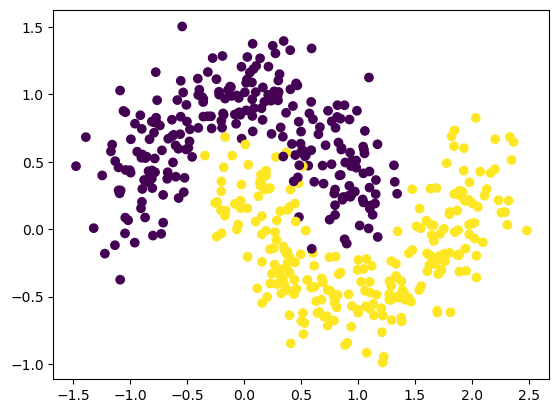

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import inspect
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression(C = 10,
                       random_state = 10) 
svm_linear = SVC(kernel='linear',
          C = 10,
         random_state = 10) 

In [35]:
def foo(var): 
    """
    To get the original variable name of variable passed to a function
    """
    lcls = inspect.stack()[2][0].f_locals
    for name in lcls:
        if id(var) == id(lcls[name]):
            return name
    return None


def plot_decisioins(clf, X,y, name = None, cv = False):
    clf.fit(X, y)
    pred = clf.predict(X)
    
    fig = plt.figure(figsize=(5, 5))
    fig = plot_decision_regions(X = X, y=y, clf=clf, legend=2)
    if not name:
        name = foo(clf)
    plt.title(name)
    plt.show()
    print(f'{name} accuracy: {np.round(accuracy_score(y, pred),3)}')
    if cv:
        print(f'{name} best params: {clf.best_params_}')
    

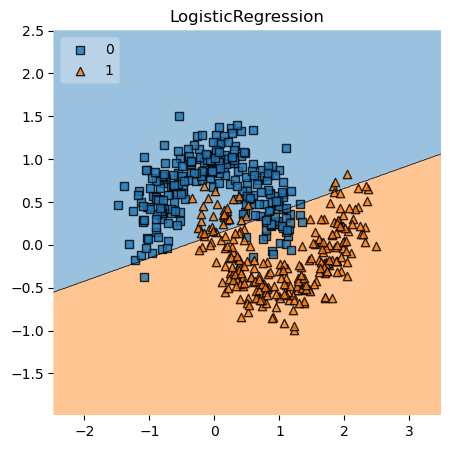

LogisticRegression accuracy: 0.86


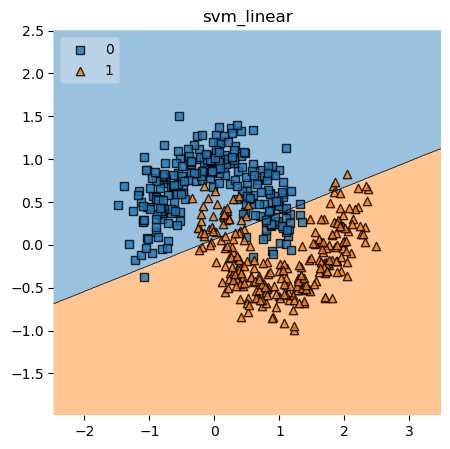

svm_linear accuracy: 0.862


In [36]:
plot_decisioins(lr, moons_points, moons_labels, name = 'LogisticRegression')
plot_decisioins(svm_linear,moons_points, moons_labels)

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [6]:
from sklearn.model_selection import GridSearchCV

In [37]:
svm_poly_CV = GridSearchCV(estimator = SVC(kernel='poly', random_state = 10),
                           param_grid = {"C": np.logspace(-3, 3, num=7), "degree": np.arange(2,8)},
                           cv = 5,
                           scoring = 'f1')

svm_sigmoid_CV = GridSearchCV(estimator = SVC(kernel='sigmoid', random_state = 10),
                           param_grid = {"C": np.logspace(-3, 3, num=7)},
                           cv = 5,
                           scoring = 'f1')

svm_rbf_CV = GridSearchCV(estimator = SVC(kernel='rbf', random_state = 10),
                           param_grid = {"C": np.logspace(-3, 3, num=7)},
                           cv = 5,
                           scoring = 'f1')

svm = [svm_linear ,svm_poly_CV, svm_rbf_CV, svm_sigmoid_CV]

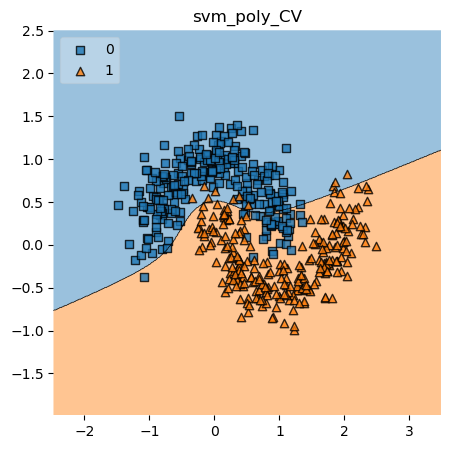

svm_poly_CV accuracy: 0.906
svm_poly_CV best params: {'C': 1.0, 'degree': 3}


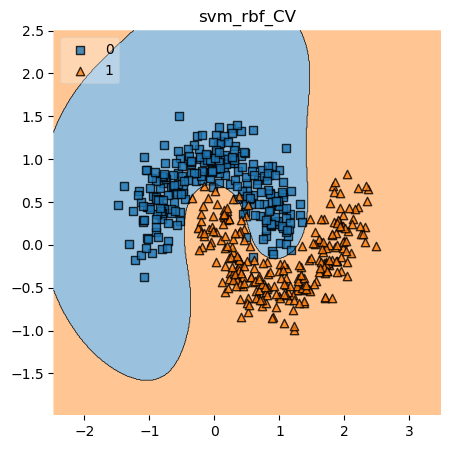

svm_rbf_CV accuracy: 0.982
svm_rbf_CV best params: {'C': 100.0}


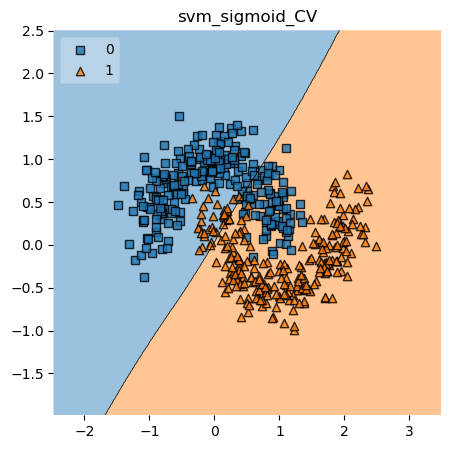

svm_sigmoid_CV accuracy: 0.778
svm_sigmoid_CV best params: {'C': 0.001}


In [38]:
for model in svm[1:]:
    plot_decisioins(model, moons_points, moons_labels, cv = True)


* **Except sigmoid kernel the quality has improved compared to the models from the previous paragraph**
* **For each kernel decision border looks like nonlinear surface, sometimes a closed curve**
* **I have chosen degree = 3 as cv estimated. However, we needed nonlinear poly ==> degree > 1, with 2 border looked like a hyperbolic paraboloid**


## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

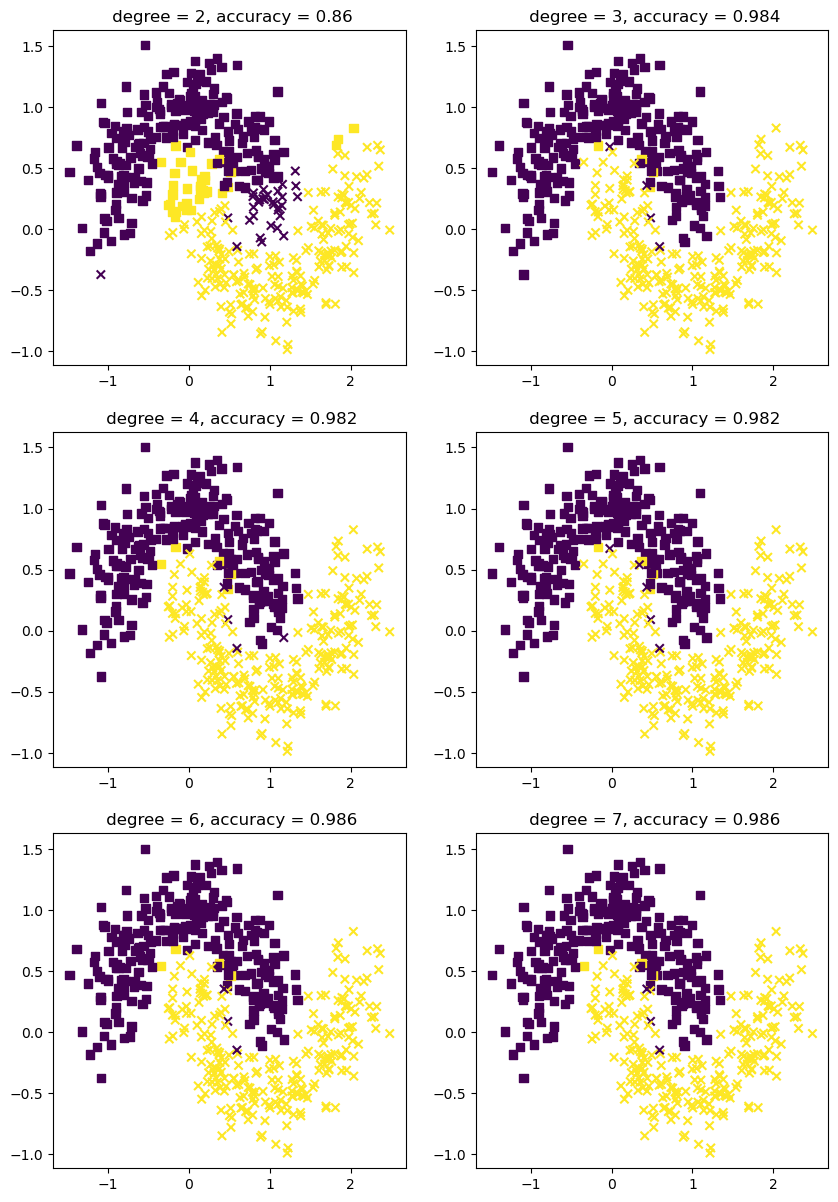

In [58]:
plt.figure(figsize=(10,20))

for i in range(2,8):
    poly = PolynomialFeatures(i)
    moons_points_poly = poly.fit_transform(moons_points)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        model = GridSearchCV(estimator = LogisticRegression(max_iter = 500, random_state = 10),
                                       param_grid = {"C": np.logspace(-3, 3, num=7)},
                                       cv = 5,
                                       scoring = 'f1')
        model.fit(moons_points_poly, moons_labels)
        pred = model.predict(moons_points_poly)

        ax = plt.subplot(4, 2, i+1)
        markers = 'sx'
        for m,k in zip(markers,np.unique(pred)):
            mask = pred==k
            ax.scatter(moons_points[mask, 0], moons_points[mask,1], c = moons_labels[mask],
                        marker = m, label=k)
        ax.set_title(f' degree = {i}, accuracy = {np.round(accuracy_score(moons_labels, pred),3)}')

plt.show()


**There markers mean placement of boundary, colours - true target class**

* **With degree = 4 we have same quality as with the best SVM model - with rbf kernel. With the same degree = 3 but bigger amount of features quality increases. With greater degree accuracy increases**


## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

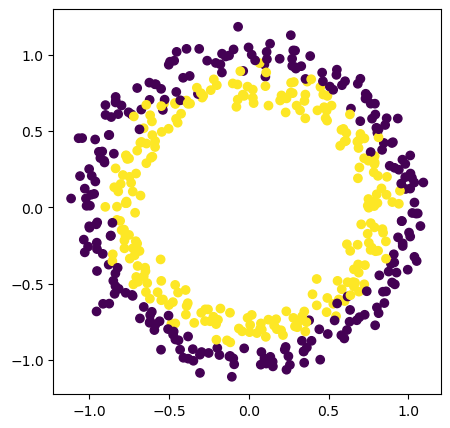

In [12]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)
None

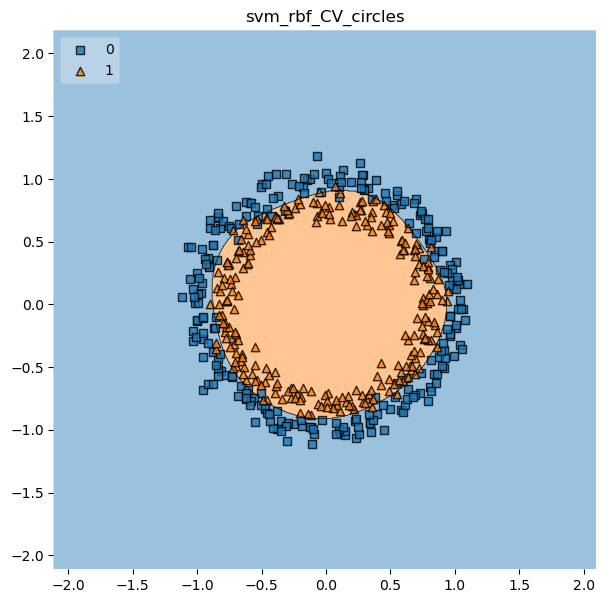

svm_rbf_CV_circles accuracy: 0.944
svm_rbf_CV_circles best params: {'C': 1000.0}


In [13]:
svm_rbf_CV_circles = GridSearchCV(estimator = SVC(kernel='rbf', random_state = 10),
                           param_grid = {"C": np.logspace(-3, 3, num=7)},
                           cv = 5,
                           scoring = 'f1')
plot_decisioins(svm_rbf_CV_circles, circles_points, circles_labels, cv = True)

In [30]:
import warnings
from sklearn.exceptions import ConvergenceWarning

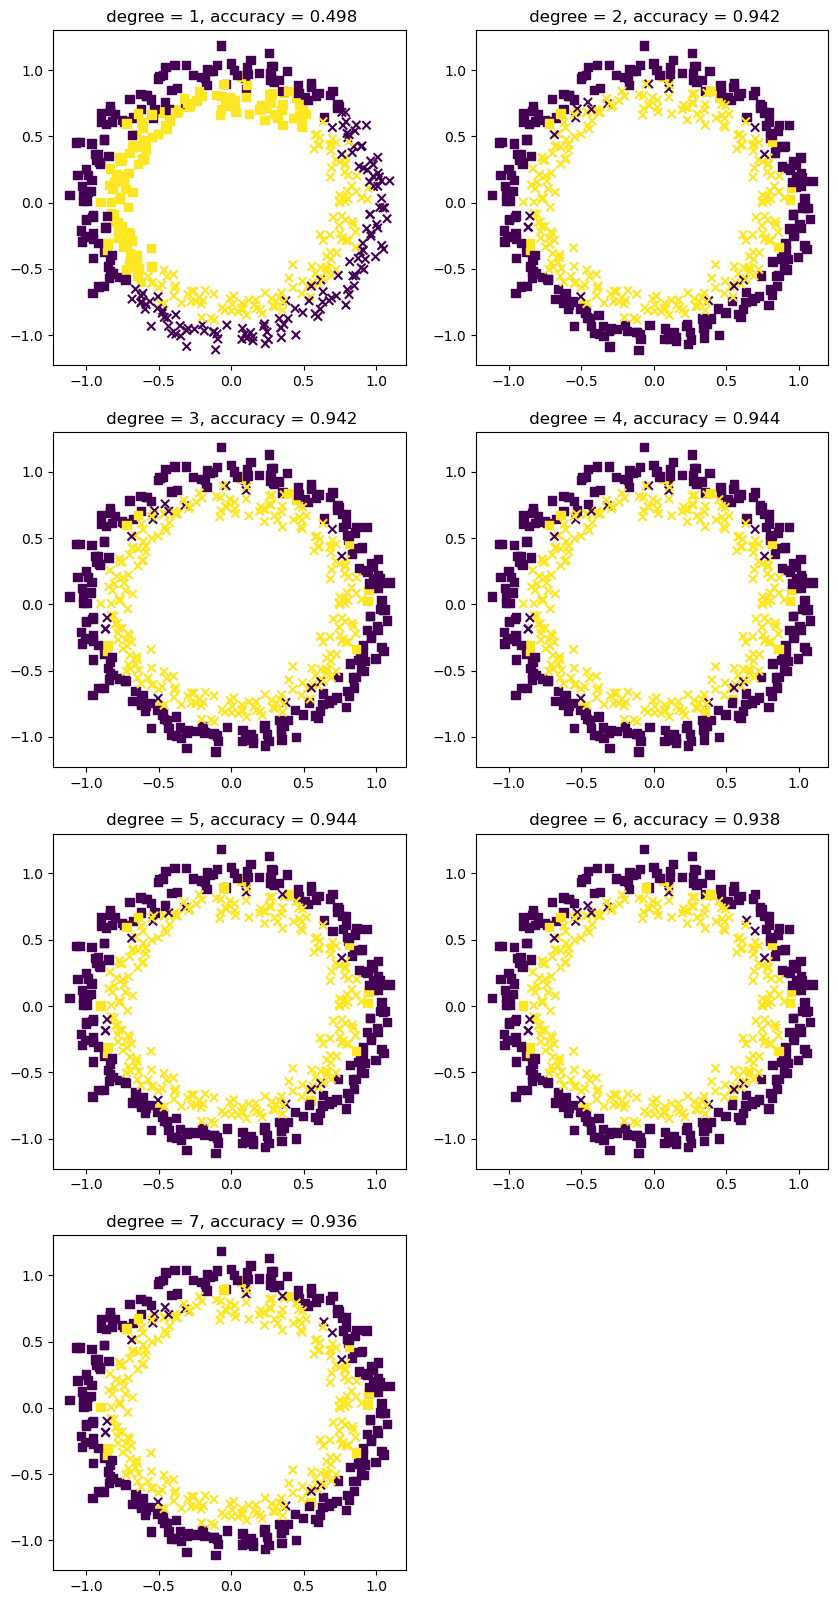

In [56]:
plt.figure(figsize=(10,20))

for i in range(1,8):
    poly = PolynomialFeatures(i)
    circles_points_poly = poly.fit_transform(circles_points)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        model = GridSearchCV(estimator = LogisticRegression(max_iter = 500, random_state = 10),
                                   param_grid = {"C": np.logspace(-3, 3, num=7)},
                                   cv = 5,
                                   scoring = 'f1')

        model.fit(circles_points_poly, circles_labels)
        pred = model.predict(circles_points_poly)

        ax = plt.subplot(4, 2, i)
        markers = 'sx'
        for m,k in zip(markers,np.unique(pred)):
            mask = pred==k
            ax.scatter(circles_points[mask, 0], circles_points[mask,1], c = circles_labels[mask],
                        marker = m, label=k)
        ax.set_title(f' degree = {i}, accuracy = {np.round(accuracy_score(circles_labels, pred),3)}')

plt.show()

**Since degree = 2 quality hasn't increased much. With degree = 4 LR works with same accuracy as SVM with rbf**

And even more:

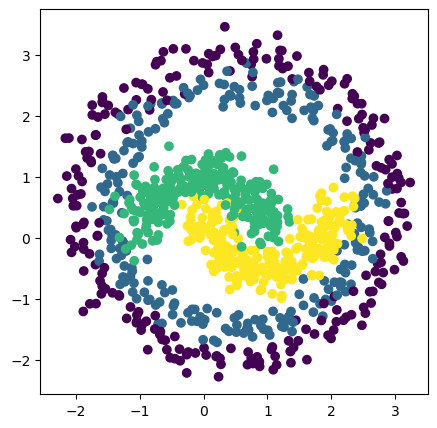

In [18]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)
None

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

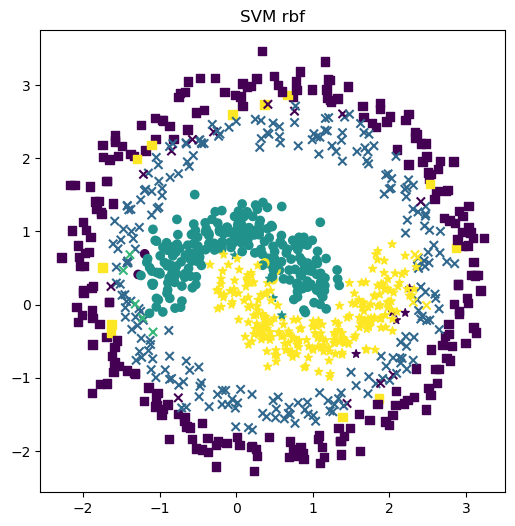

SVM rbf accuracy: 0.952
SVM rbf best params: {'C': 1000.0}


In [24]:
svm_rbf_CV_hard = GridSearchCV(estimator = SVC(kernel='rbf', random_state = 10),
                           param_grid = {"C": np.logspace(-3, 3, num=7)},
                           cv = 5,
                           scoring = 'f1_macro')

svm_rbf_CV_hard.fit(points, labels)
pred = svm_rbf_CV_hard.predict(points)

plt.figure(figsize=(6,6))
markers = 'sxo*'
for m,k in zip(markers,np.unique(pred)):
    mask = pred==k
    plt.scatter(points[mask, 0], points[mask,1], c = labels[mask],
                marker = m, label=k)
plt.title('SVM rbf')
plt.show()
print(f'SVM rbf accuracy: {np.round(accuracy_score(labels, pred),3)}')
print(f'SVM rbf best params: {svm_rbf_CV_hard.best_params_}')



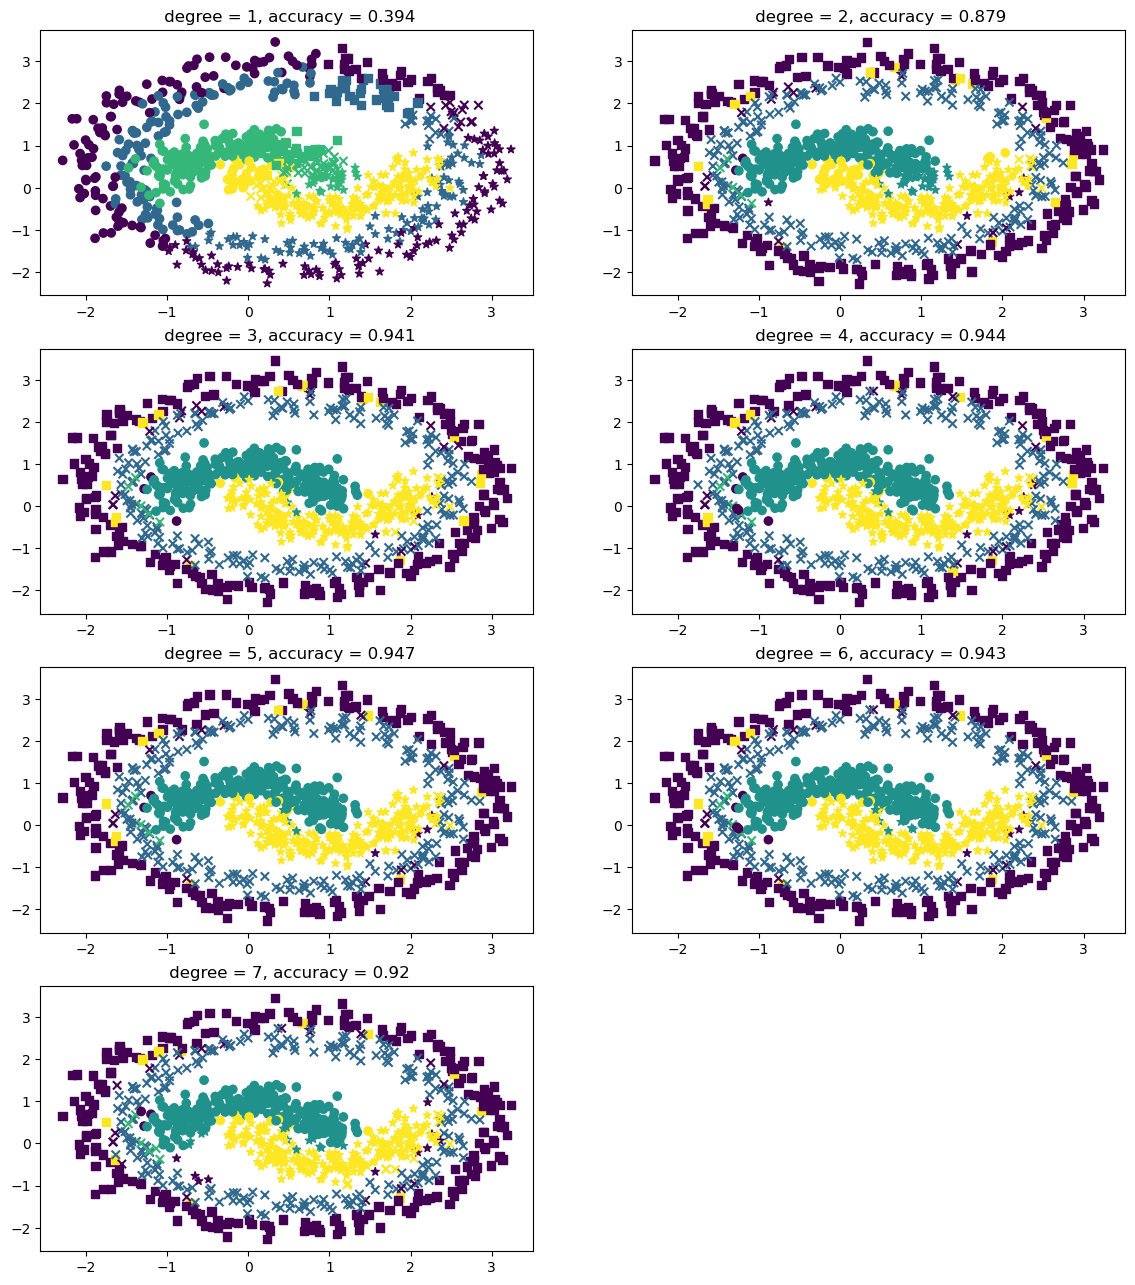

In [60]:
plt.figure(figsize=(20,20))
for i in range(1,8):
    poly = PolynomialFeatures(i)
    points_poly = poly.fit_transform(points)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        model = GridSearchCV(estimator = LogisticRegression(max_iter = 500, random_state = 10),
                               param_grid = {"C": np.logspace(-3, 3, num=7)},
                               cv = 5,
                               scoring = 'f1_macro')

        model.fit(points_poly, labels)
        pred = model.predict(points_poly)

        ax = plt.subplot(5, 2, i)
        markers = 'sxo*'
        for m,k in zip(markers,np.unique(pred)):
            mask = pred==k
            ax.scatter(points[mask, 0], points[mask,1], c = labels[mask],
                        marker = m, label=k)
        ax.set_title(f' degree = {i}, accuracy = {np.round(accuracy_score(labels, pred),3)}')

plt.show()

**Noticeably that after degree = 5 accuracy starts to decrease, anyway rbf kernel works better than LR with any degree value**